# Basic Adversarial Examples

## Copyright notice

This version (c) 2019 Fabian Offert, [MIT License](LICENSE).

## Imports

We are using PyTorch as our deep learning framework.

In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

import numpy as np

import os
import random
from io import BytesIO
import PIL.Image
from PIL import ImageChops
import IPython.display

## Model to attack

We are using the (very common) InceptionV3 architecture, pre-trained on ImageNet.

In [ ]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu") # Use GPU if available
f = tv.models.inception_v3(pretrained=True).to(device)
# Test mode: we do not want to train the model (i.e. change its weights) at any point
f.eval()

## Helper functions

Among other things, these helper functions allow us to convert between PyTorch tensors, NumPy arrays, and PIL images.

In [189]:
# Show an image within a Jupyter environment
# Can do PyTorch tensors, NumPy arrays, and PIL images
def show_img(img, title='', fmt='jpeg'):
    if type(img) is np.ndarray:
        img = PIL.Image.fromarray(img)
    elif type(img) is t.Tensor:
        img = deprocess(img)
    f = BytesIO()
    if title: print(title)
    img.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

# PyTorch is channels first, this happens here!
preprocess = tv.transforms.Compose([tv.transforms.ToTensor()])
    
# Reverse of preprocess, PyTorch tensor to PIL image
def deprocess(tensor):
    # Clone tensor first, otherwise we are NOT making a copy by using .cpu()!
    img = t.clone(tensor)
    img = img.cpu().data.numpy().squeeze() # Get rid of batch dimension
    img = img.transpose((1, 2, 0)) # Channels first to channels last
    
    # We are not using ImageNet images as input
    # mean = np.array([0.485, 0.456, 0.406]) 
    # std = np.array([0.229, 0.224, 0.225]) 
    # img = std * img + mean

    # No clipping, adversarial regulation should take care of this
    # img = np.clip(img, 0, 1)
    
    img *= 255
    img = img.astype(np.uint8)
    img = PIL.Image.fromarray(img)
    
    return img

# Return a gray square PIL image
def gray_square(size):
    # Gray square, -1./1. range
    img = np.random.normal(0, 0.01, (size, size, 3)) 
    
    # -1./1. range to 0./255. range
    img /= 2.
    img += 0.5
    img *= 255.

    # To PIL image format
    img = PIL.Image.fromarray(img.astype(np.uint8))
    
    return img

# Load ImageNet classes
with open('synset_words.txt') as synset_words_file:
    synset_words = synset_words_file.readlines()
for i, line in enumerate(synset_words):
    synset_words[i] = line.replace(' ', '_').replace(',', '_').lower().strip()

# Classify an image with the target model 
# Can do PyTorch tensors and PIL images
def predict(img):
    if type(img) is t.Tensor:
        preds = f(img.to(device))
    else:
        preds = f(preprocess(img).unsqueeze(0).to(device))
    preds_softmax_np = F.softmax(preds, dim=1).cpu().data.numpy()
    # Returns class no., class name, and prediction confidence
    return preds_softmax_np.argmax(), synset_words[preds_softmax_np.argmax()], preds_softmax_np.max()

# "Rolling" list: whenever an item is added, the first item is discarded
def destructive_append(l,i):
    l=l[1:]
    l.append(i)
    return l

## Attacks

### Fast Gradient Sign Method (FGSM)

From: Goodfellow, I.J., Shlens, J., Szegedy, C., 2014. Explaining and harnessing adversarial examples. arXiv preprint arXiv:1412.6572.

In [4]:
def fgsm(img, neuron):
    
    ε = 0.007 # Pertuberation amount
    
    # Preprocess input image and put on GPU
    input = preprocess(img).unsqueeze(0).to(device).requires_grad_()
    
    # Reset gradients
    f.zero_grad()
    
    # Forward pass
    x = f(input)
    
    # Use true label as optimum
    loss = nn.CrossEntropyLoss()
    # nn.CrossEntropyLoss() counter-intuitively does NOT take a one-hot vector as target!
    label = t.tensor([neuron], dtype=t.long).to(device)
    cost = loss(x, label)
    cost.backward()
    
    attack_img = input + ε*input.grad.sign()
    attack_img = t.clamp(attack_img, 0.0, 1.0)
    
    return attack_img

### Expectation over Transformation Method (ETO) / Adversarial Patch

From: Brown, T.B., Mané, D., Roy, A., Abadi, M., Gilmer, J., 2017. Adversarial patch. arXiv preprint arXiv:1712.09665, Athalye, A., Engstrom, L., Ilyas, A. and Kwok, K., 2017. Synthesizing robust adversarial examples. arXiv preprint arXiv:1707.07397.

Note: Only partially implemented (patch location) at this point.

In [135]:
def eto(img, neuron):
        
    LR = 0.4 # Learning rate
    MIN_CONFIDENCE = 0.99 # Minimum prediction confidence to stop optimization
    L2 = 1e-4 # Yosinski weight decay
    
    bg = PIL.Image.open('erika_299x299.jpg') # Fixed background for now
    assert bg.width == bg.height # Assert background is square
    assert img.width == img.height # Assert image to be optimized is square
    assert img.width < bg.width # Assert image to be optimized is smaller than background

    input = preprocess(img).unsqueeze(0).to(device).requires_grad_()
    npbg = preprocess(bg).unsqueeze(0).data.cpu().numpy() # To tensor and back so we don not have to deal with channels etc.
    optimizer = t.optim.SGD([input], lr=LR, weight_decay=L2)
    
    max_shift = npbg.shape[2]-input.shape[2]
    
    # We want to keep a running average, as the patch location is constantly changing
    mem_confidence = 100
    acc_confidence = [0.0 for i in range(mem_confidence)]
    avg_confidence = 0.0
    confidence = 0.0
    
    iteration = 0
    
    while avg_confidence < MIN_CONFIDENCE:
        
        optimizer.zero_grad()
        
        # TO DO: load random background image
        # TO DO: scaling and rotation
        npimg = input.data.cpu().numpy()
        x_shift = np.random.randint(max_shift)
        y_shift = np.random.randint(max_shift)
        npcombined = npbg.copy()
        npcombined[:,:,y_shift:y_shift+img.height,x_shift:x_shift+img.width] = npimg
        input.data = t.from_numpy(npcombined).to(device)
        
        x = f(input)
        loss = -x[:,neuron] # -x as the optimizer wants to minimize loss and we want to maximize class probability
    
        preds_softmax_np = F.softmax(x, dim=1).cpu().data.numpy()
        confidence = preds_softmax_np[:,neuron]
        
        acc_confidence = destructive_append(acc_confidence, confidence)
        avg_confidence = sum(acc_confidence)/mem_confidence
            
        iteration += 1
        
        if iteration%100 == 0: 
            print(f'Iterations: {iteration}, loss: {loss.item()}, pred.: {synset_words[preds_softmax_np.argmax()]}, avg. conf. target: {avg_confidence}')
            
        loss.backward()
        optimizer.step()
        
        npcombined = input.data.cpu().numpy()
        npimg = npcombined[:,:,y_shift:y_shift+img.height,x_shift:x_shift+img.width]
        input.data = t.from_numpy(npimg).to(device)
    
    return input

### Iterative Least-Likely Class Method (ILLC)

From: Kurakin, A., Goodfellow, I. and Bengio, S., 2016. Adversarial examples in the physical world. arXiv preprint arXiv:1607.02533.

In [6]:
def illc(img, neuron):
    
    LR = 0.01 # Learning rate
    ε = 0.01 # Max pertuberation amount
    MIN_CONFIDENCE = 0.99 # Minimum prediction confidence to stop optimization

    input = preprocess(img).unsqueeze(0).to(device).requires_grad_()
    original = input.data.cpu().numpy()
    optimizer = t.optim.SGD([input], lr=LR)
    
    iteration = 0
    confidence = 0.0
    
    while confidence < MIN_CONFIDENCE:
        
        optimizer.zero_grad()
        
        x = f(input)
        loss = -x[:,neuron] # -x as the optimizer wants to minimize loss and we want to maximize class probability
        
        preds_softmax_np = F.softmax(x, dim=1).cpu().data.numpy()
        confidence = preds_softmax_np[:,neuron]
        
        iteration += 1
            
        if iteration%50 == 0: 
            print(f'Iterations: {iteration}, loss: {loss.item()}, pred.: {synset_words[preds_softmax_np.argmax()]}, conf. target: {confidence}')

        loss.backward()
        optimizer.step()
        
        # Regular and adversarial clipping on the CPU (don't mess with GPU tensors in place!)
        img = input.data.cpu().numpy()
        
        clipped = np.where(img > original + ε, original + ε, img)
        clipped = np.where(clipped < original - ε, original - ε, clipped)
        # We could also use t.clamp() but as we are manipulating CPU representations anyway...
        clipped = np.where(clipped > 1.0, 1.0, clipped)
        clipped = np.where(clipped < 0.0, 0.0, clipped)
        
        input.data = t.from_numpy(clipped).to(device)
    
    return input

## Demos

### Load sample images

In [136]:
erika = PIL.Image.open('erika_299x299.jpg')
giant_panda = PIL.Image.open('giant_panda_299x299.jpg')
giant_panda_id, _, _ = predict(giant_panda)

### FGSM

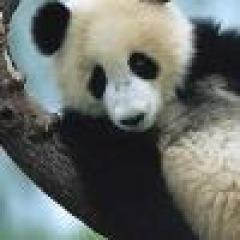

(388, 'giant_panda__panda__panda_bear__coon_bear__ailuropoda_melanoleuca', 0.9992046)


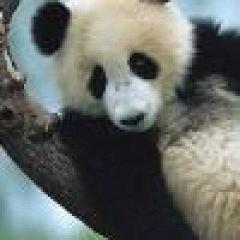

(259, 'pomeranian', 0.6166522)


In [8]:
# Regular image and predictions
show_img(giant_panda)
print(predict(giant_panda))

# Attack
img = fgsm(giant_panda, giant_panda_id)

# Adversarial image and predictions
show_img(img)
print(predict(img))

### ILLC

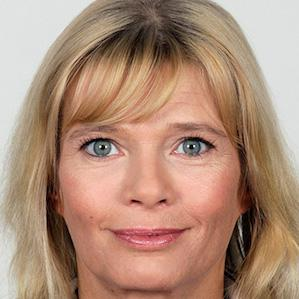

Iterations: 50, loss: -2.9871766567230225, pred.: sunscreen__sunblock__sun_blocker, conf. target: [0.00613597]
Iterations: 100, loss: -5.525441646575928, pred.: ice_lolly__lolly__lollipop__popsicle, conf. target: [0.05524244]
Iterations: 150, loss: -7.317103385925293, pred.: goldfish__carassius_auratus, conf. target: [0.20719677]
Iterations: 200, loss: -8.527125358581543, pred.: goldfish__carassius_auratus, conf. target: [0.39637]
Iterations: 250, loss: -9.709080696105957, pred.: goldfish__carassius_auratus, conf. target: [0.627496]
Iterations: 300, loss: -10.857205390930176, pred.: goldfish__carassius_auratus, conf. target: [0.80342424]
Iterations: 350, loss: -12.327896118164062, pred.: goldfish__carassius_auratus, conf. target: [0.93704975]
Iterations: 400, loss: -13.509681701660156, pred.: goldfish__carassius_auratus, conf. target: [0.9754024]
Iterations: 450, loss: -14.267879486083984, pred.: goldfish__carassius_auratus, conf. target: [0.98574173]


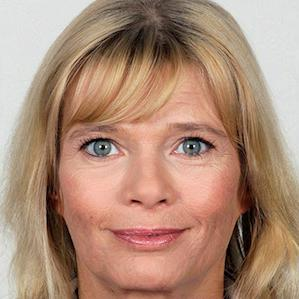

(1, 'goldfish__carassius_auratus', 0.9899614)


In [177]:
# Regular image
show_img(erika)

# Attack
img = illc(erika, 1) # 1 = Goldfish

# Adversarial image and prediction
show_img(img)
print(predict(img))

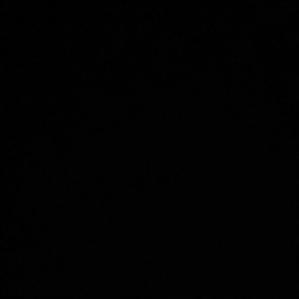

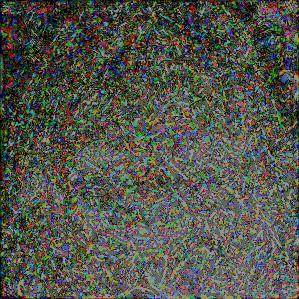

In [178]:
diff = ImageChops.difference(deprocess(img), erika)
show_img(diff)
show_img(np.array(diff)*50)

### ETO

Iterations: 100, loss: -14.534438133239746, pred.: goldfish__carassius_auratus, avg. conf. target: [0.1814685]
Iterations: 200, loss: -13.606766700744629, pred.: goldfish__carassius_auratus, avg. conf. target: [0.95678794]
Iterations: 300, loss: -18.031702041625977, pred.: goldfish__carassius_auratus, avg. conf. target: [0.97511435]
Iterations: 400, loss: -19.014917373657227, pred.: goldfish__carassius_auratus, avg. conf. target: [0.9818616]
Iterations: 500, loss: -18.426359176635742, pred.: goldfish__carassius_auratus, avg. conf. target: [0.9820721]


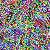

In [183]:
img = eto(gray_square(50), 1) # 1 = Goldfish
show_img(img)

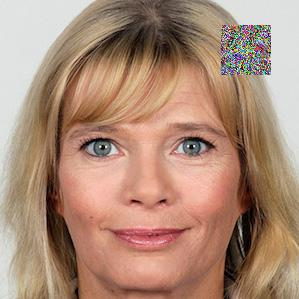

(1, 'goldfish__carassius_auratus', 0.9997389)


In [190]:
bg = PIL.Image.open('erika_299x299.jpg')
npbg = preprocess(bg).unsqueeze(0).data.cpu().numpy()
npimg = img.data.cpu().numpy()
max_shift = npbg.shape[2]-img.shape[2]

for i in range(1):
    x_shift = np.random.randint(max_shift)
    y_shift = np.random.randint(max_shift)
    npcombined = npbg.copy()
    npcombined[:,:,y_shift:y_shift+img.shape[2],x_shift:x_shift+img.shape[2]] = npimg
    show_img(t.from_numpy(npcombined))
    print(predict(t.from_numpy(npcombined)))